In [1]:
#! Tin 
from IPython.display import clear_output  
import randomizeSequence as rSeq
import ScrappySequence as ss
import math
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

#!/usr/bin/env python
import os
import json
import time
import argparse
from tqdm import tqdm
from collections import defaultdict
import math
import argparse
import importlib

# torchim:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
# from tensorboardX import SummaryWriter
import numpy as np
import pytorch_warmup as warmup

# data:
import data
from data.collate import collate_fn, gpu_collate, no_pad_collate
from data.transforms import (
    Compose, AddLengths, AudioSqueeze, TextPreprocess,
    MaskSpectrogram, ToNumpy, BPEtexts, MelSpectrogram,
    ToGpu, Pad, NormalizedMelSpectrogram
)
import youtokentome as yttm

import torchaudio
from audiomentations import (
    TimeStretch, PitchShift, AddGaussianNoise
)
from functools import partial

# model:
from model import configs as quartznet_configs
from model.quartznet import QuartzNet

# utils:
import yaml
from easydict import EasyDict as edict
from utils import fix_seeds, remove_from_dict, prepare_bpe
import wandb
from decoder import GreedyDecoder, BeamCTCDecoder

import youtokentome as yttm
from gen_data_func import *

In [2]:
print(os.getcwd())
data_file_name = "out_csv/testing_out.csv"
samples_per_sequence = 3

In [3]:
start = time.monotonic()
signals,index,spacer_labels, letter_labels, barcode_labels, ctc_labels =prepare_train2(data_file_name, samples_per_sequence)
end = time.monotonic()
print(f"Generated {len(signals)} signals and {len(spacer_labels)} labels", f"in {end-start}")
#Sequential: 26.099690708000026

In [4]:
len(signals)

9

In [5]:
plt.figure(figsize=(30, 10))
i  = 0
plt.plot(signals[i])
plt.plot(spacer_labels[i])
print("Letters:", letter_labels[i], "\nbarcodes:", barcode_labels[i], '\nctc_labels:', ctc_labels[i])

print(len(signals))
# print(len(signals[i]))
print(([len(x) for x in signals]))
print(max([len(x) for x in signals]))

In [6]:
#Create a "SignalDataset" class by importing the Pytorch Dataset class
class Dataset_ctc(Dataset):
    """ Data noisey sinewave dataset
        num_datapoints - the number of datapoints you want
    """
    def __init__(self, x,y):
        self.x_data = x
        self.y_data = y

    #called by the dataLOADER class whenever it wants a new mini-batch
    #returns corresponding input datapoints AND the corresponding labels
    def __getitem__(self, index):
        return {'audio': np.array(self.x_data[index]), 'text': np.array(self.y_data[index]), 'sample_rate': 22050}
        
    #length of the dataset
    def __len__(self):
        return len(self.x_data)

In [7]:

# TODO: wrap to trainer class

parser = argparse.ArgumentParser(description='Training model.')
parser.add_argument('--config', default='configs/train_LJSpeech.yaml',
                    help='path to config file')
args = parser.parse_args("")
with open(args.config, 'r') as f:
    config = edict(yaml.safe_load(f))

def write_to_file(str_w, file_name = 'sth.txt', mode = 'w'):
    with open(file_name,mode) as f:
        f.write(str(str_w))

In [8]:
# config

In [9]:
fix_seeds(seed=config.train.get('seed', 42))
dataset_module = importlib.import_module(
    f'.{config.dataset.name}', data.__name__)
bpe = prepare_bpe(config)

transforms_train = Compose([
    # TextPreprocess(),# removing punctuation in text - might not needed
    # ToNumpy(), # convert audio to numpy
    # BPEtexts(bpe=bpe, dropout_prob=config.bpe.get('dropout_prob', 0.05)),
    # AudioSqueeze(), # remove 1st dimension if it is 1 [1,...]
    # AddGaussianNoise(
    #     min_amplitude=0.001,
    #     max_amplitude=0.015,
    #     p=0.5
    # ),
    # TimeStretch(
    #     min_rate=0.8,
    #     max_rate=1.25,
    #     p=0.5
    # ),
    # PitchShift(
    #     min_semitones=-4,
    #     max_semitones=4,
    #     p=0.5
    # )
    # AddLengths()
])

batch_transforms_train = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    # NormalizedMelSpectrogram(
    #     sample_rate=config.dataset.get('sample_rate', 16000),
    #     n_mels=config.model.feat_in,
    #     normalize=config.dataset.get('normalize', None)
    # ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    # MaskSpectrogram(
    #     probability=0.5,
    #     time_mask_max_percentage=0.05,
    #     frequency_mask_max_percentage=0.15
    # ),
    AudioUnsqueeze(),
    AddLengths(),
    Pad()
])

transforms_val = Compose([
#     TextPreprocess(),
#     ToNumpy(),
#     BPEtexts(bpe=bpe),
#     AudioSqueeze()
])

batch_transforms_val = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    NormalizedMelSpectrogram(
        sample_rate=config.dataset.get(
            'sample_rate', 16000),  # for LJspeech
        n_mels=config.model.feat_in,
        normalize=config.dataset.get('normalize', None)
    ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    AddLengths(),
    Pad() # pad both audio and text
])

# load datasets
# train_dataset = dataset_module.get_dataset(
#     config, transforms=transforms_train, part='train')
# val_dataset = dataset_module.get_dataset(
#     config, transforms=transforms_val, part='val')

# ! TIN Dataset
train_dataset = Dataset_ctc(signals,ctc_labels)
val_dataset = Dataset_ctc(signals,ctc_labels)

# print("!!!", config.train.get('num_workers', 4))
train_dataloader = DataLoader(train_dataset, 
                                batch_size=config.train.get('batch_size', 1), collate_fn=no_pad_collate)

val_dataloader = DataLoader(val_dataset, 
                            batch_size=1, collate_fn=no_pad_collate)

print(getattr(quartznet_configs, config.model.name, '_quartznet5x5_config'))

model = QuartzNet(
    model_config=getattr(
        quartznet_configs, config.model.name, '_quartznet5x5_config'),
    **remove_from_dict(config.model, ['name'])
)
# model = QuartzNet(
#     model_config=getattr(
#         quartznet_configs, config.model.name, '_quartznet5x5_config'),**config)


# print(model)
write_to_file(model,'model_structure.txt')

optimizer = torch.optim.Adam(
    model.parameters(), **config.train.get('optimizer', {}))
num_steps = len(train_dataloader) * config.train.get('epochs', 10)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_steps)
# warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)

if config.train.get('from_checkpoint', None) is not None:
    model.load_weights(config.train.from_checkpoint)

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
# criterion = nn.CTCLoss(blank=config.model.vocab_size)
decoder = GreedyDecoder(bpe=bpe)

prev_wer = 1000
wandb.init(project=config.wandb.project, config=config)
wandb.watch(model, log="all", log_freq=config.wandb.get(
    'log_interval', 5000))

In [10]:
#! Tin 
from IPython.display import clear_output  
import randomizeSequence as rSeq
import ScrappySequence as ss
import math
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

#!/usr/bin/env python
import os
import json
import time
import argparse
from tqdm import tqdm
from collections import defaultdict
import math
import argparse
import importlib

# torchim:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
# from tensorboardX import SummaryWriter
import numpy as np
import pytorch_warmup as warmup

# data:
import data
from data.collate import collate_fn, gpu_collate, no_pad_collate
from data.transforms import (
    Compose, AddLengths, AudioSqueeze, TextPreprocess,
    MaskSpectrogram, ToNumpy, BPEtexts, MelSpectrogram,
    ToGpu, Pad, NormalizedMelSpectrogram, AudioUnsqueeze
)
import youtokentome as yttm

import torchaudio
from audiomentations import (
    TimeStretch, PitchShift, AddGaussianNoise
)
from functools import partial

# model:
from model import configs as quartznet_configs
from model.quartznet import QuartzNet

# utils:
import yaml
from easydict import EasyDict as edict
from utils import fix_seeds, remove_from_dict, prepare_bpe
import wandb
from decoder import GreedyDecoder, BeamCTCDecoder

import youtokentome as yttm
from gen_data_func import *

In [11]:
fix_seeds(seed=config.train.get('seed', 42))
dataset_module = importlib.import_module(
    f'.{config.dataset.name}', data.__name__)
bpe = prepare_bpe(config)

transforms_train = Compose([
    # TextPreprocess(),# removing punctuation in text - might not needed
    # ToNumpy(), # convert audio to numpy
    # BPEtexts(bpe=bpe, dropout_prob=config.bpe.get('dropout_prob', 0.05)),
    # AudioSqueeze(), # remove 1st dimension if it is 1 [1,...]
    # AddGaussianNoise(
    #     min_amplitude=0.001,
    #     max_amplitude=0.015,
    #     p=0.5
    # ),
    # TimeStretch(
    #     min_rate=0.8,
    #     max_rate=1.25,
    #     p=0.5
    # ),
    # PitchShift(
    #     min_semitones=-4,
    #     max_semitones=4,
    #     p=0.5
    # )
    # AddLengths()
])

batch_transforms_train = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    # NormalizedMelSpectrogram(
    #     sample_rate=config.dataset.get('sample_rate', 16000),
    #     n_mels=config.model.feat_in,
    #     normalize=config.dataset.get('normalize', None)
    # ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    # MaskSpectrogram(
    #     probability=0.5,
    #     time_mask_max_percentage=0.05,
    #     frequency_mask_max_percentage=0.15
    # ),
    AudioUnsqueeze(),
    AddLengths(),
    Pad()
])

transforms_val = Compose([
#     TextPreprocess(),
#     ToNumpy(),
#     BPEtexts(bpe=bpe),
#     AudioSqueeze()
])

batch_transforms_val = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    NormalizedMelSpectrogram(
        sample_rate=config.dataset.get(
            'sample_rate', 16000),  # for LJspeech
        n_mels=config.model.feat_in,
        normalize=config.dataset.get('normalize', None)
    ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    AddLengths(),
    Pad() # pad both audio and text
])

# load datasets
# train_dataset = dataset_module.get_dataset(
#     config, transforms=transforms_train, part='train')
# val_dataset = dataset_module.get_dataset(
#     config, transforms=transforms_val, part='val')

# ! TIN Dataset
train_dataset = Dataset_ctc(signals,ctc_labels)
val_dataset = Dataset_ctc(signals,ctc_labels)

# print("!!!", config.train.get('num_workers', 4))
train_dataloader = DataLoader(train_dataset, 
                                batch_size=config.train.get('batch_size', 1), collate_fn=no_pad_collate)

val_dataloader = DataLoader(val_dataset, 
                            batch_size=1, collate_fn=no_pad_collate)

print(getattr(quartznet_configs, config.model.name, '_quartznet5x5_config'))

model = QuartzNet(
    model_config=getattr(
        quartznet_configs, config.model.name, '_quartznet5x5_config'),
    **remove_from_dict(config.model, ['name'])
)
# model = QuartzNet(
#     model_config=getattr(
#         quartznet_configs, config.model.name, '_quartznet5x5_config'),**config)


# print(model)
write_to_file(model,'model_structure.txt')

optimizer = torch.optim.Adam(
    model.parameters(), **config.train.get('optimizer', {}))
num_steps = len(train_dataloader) * config.train.get('epochs', 10)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_steps)
# warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)

if config.train.get('from_checkpoint', None) is not None:
    model.load_weights(config.train.from_checkpoint)

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
# criterion = nn.CTCLoss(blank=config.model.vocab_size)
decoder = GreedyDecoder(bpe=bpe)

prev_wer = 1000
wandb.init(project=config.wandb.project, config=config)
wandb.watch(model, log="all", log_freq=config.wandb.get(
    'log_interval', 5000))

[]

In [12]:
b=train_dataset.__getitem__(2)
b['audio'].shape

(1871,)

In [13]:
a=next(iter(train_dataloader))
print(len(a))
print(len(a['audio']))
print(len(a['text']))
print(len(a['audio'][0]))
# print(len(a['text'][1]))

b=batch_transforms_train(a)
print(len(b))
print(len(b['audio']))
print(len(b['text']))
print((b['audio']).shape)
print(b['text'].shape)

In [14]:
a=next(iter(train_dataloader))
print(len(a))
print(len(a['audio']))
print(len(a['text']))
print(len(a['audio'][0]))
# print(len(a['text'][1]))

batch_transforms_train = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    # NormalizedMelSpectrogram(
    #     sample_rate=config.dataset.get('sample_rate', 16000),
    #     n_mels=config.model.feat_in,
    #     normalize=config.dataset.get('normalize', None)
    # ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    # MaskSpectrogram(
    #     probability=0.5,
    #     time_mask_max_percentage=0.05,
    #     frequency_mask_max_percentage=0.15
    # ),
    AudioUnsqueeze(),
    AddLengths(),
    Pad()
])

b=batch_transforms_train(a)
print(len(b))
print(len(b['audio']))
print(len(b['text']))
print((b['audio']).shape)
print(b['text'].shape)

In [15]:
a=next(iter(train_dataloader))
print(len(a))
print(len(a['audio']))
print(len(a['text']))
print(len(a['audio'][0]))
# print(len(a['text'][1]))

batch_transforms_train = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    # NormalizedMelSpectrogram(
    #     sample_rate=config.dataset.get('sample_rate', 16000),
    #     n_mels=config.model.feat_in,
    #     normalize=config.dataset.get('normalize', None)
    # ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    # MaskSpectrogram(
    #     probability=0.5,
    #     time_mask_max_percentage=0.05,
    #     frequency_mask_max_percentage=0.15
    # ),
    # AudioUnsqueeze(),
    # AddLengths(),
    # Pad()
])

b=batch_transforms_train(a)
print(len(b))
print(len(b['audio']))
print(len(b['text']))
print((b['audio']).shape)
print(b['text'].shape)

In [16]:
a=next(iter(train_dataloader))
print(len(a))
print(len(a['audio']))
print(len(a['text']))
print(len(a['audio'][0]))
# print(len(a['text'][1]))

batch_transforms_train = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    # NormalizedMelSpectrogram(
    #     sample_rate=config.dataset.get('sample_rate', 16000),
    #     n_mels=config.model.feat_in,
    #     normalize=config.dataset.get('normalize', None)
    # ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    # MaskSpectrogram(
    #     probability=0.5,
    #     time_mask_max_percentage=0.05,
    #     frequency_mask_max_percentage=0.15
    # ),
    # AudioUnsqueeze(),
    AddLengths(),
    Pad()
])

b=batch_transforms_train(a)
print(len(b))
print(len(b['audio']))
print(len(b['text']))
print((b['audio']).shape)
print(b['text'].shape)

In [17]:
a=next(iter(train_dataloader))
print(len(a))
print(len(a['audio']))
print(len(a['text']))
print(len(a['audio'][0]))
# print(len(a['text'][1]))

batch_transforms_train = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    # NormalizedMelSpectrogram(
    #     sample_rate=config.dataset.get('sample_rate', 16000),
    #     n_mels=config.model.feat_in,
    #     normalize=config.dataset.get('normalize', None)
    # ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    # MaskSpectrogram(
    #     probability=0.5,
    #     time_mask_max_percentage=0.05,
    #     frequency_mask_max_percentage=0.15
    # ),
    AddLengths(),
    Pad(),
    AudioUnsqueeze()
])

b=batch_transforms_train(a)
print(len(b))
print(len(b['audio']))
print(len(b['text']))
print((b['audio']).shape)
print(b['text'].shape)

In [18]:
a=next(iter(train_dataloader))
print(len(a))
print(len(a['audio']))
print(len(a['text']))
print(len(a['audio'][0]))
# print(len(a['text'][1]))

batch_transforms_train = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    # NormalizedMelSpectrogram(
    #     sample_rate=config.dataset.get('sample_rate', 16000),
    #     n_mels=config.model.feat_in,
    #     normalize=config.dataset.get('normalize', None)
    # ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    # MaskSpectrogram(
    #     probability=0.5,
    #     time_mask_max_percentage=0.05,
    #     frequency_mask_max_percentage=0.15
    # ),
    AddLengths(),
    Pad(),
    AudioUnsqueeze()
])

b=batch_transforms_train(a)
print(len(b))
print(len(b['audio']))
print(len(b['text']))
print((b['audio']).shape)
print(b['text'].shape)

In [19]:
a=next(iter(train_dataloader))
print(len(a))
print(len(a['audio']))
print(len(a['text']))
print(len(a['audio'][0]))
# print(len(a['text'][1]))

batch_transforms_train = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    # NormalizedMelSpectrogram(
    #     sample_rate=config.dataset.get('sample_rate', 16000),
    #     n_mels=config.model.feat_in,
    #     normalize=config.dataset.get('normalize', None)
    # ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    # MaskSpectrogram(
    #     probability=0.5,
    #     time_mask_max_percentage=0.05,
    #     frequency_mask_max_percentage=0.15
    # ),
    AddLengths(),
    Pad(),
    # AudioUnsqueeze()
])

b=batch_transforms_train(a)
print(len(b))
print(len(b['audio']))
print(len(b['text']))
print((b['audio']).shape)
print(b['text'].shape)

In [20]:
class AudioUnsqueeze:
    def __call__(self, data):
        data['audio'] = data['audio'].unsqueeze(1)
        return data

In [21]:
a=next(iter(train_dataloader))
print(len(a))
print(len(a['audio']))
print(len(a['text']))
print(len(a['audio'][0]))
# print(len(a['text'][1]))

b=batch_transforms_train(a)
print(len(b))
print(len(b['audio']))
print(len(b['text']))
print((b['audio']).shape)
print(b['text'].shape)

In [22]:
#! Tin 
from IPython.display import clear_output  
import randomizeSequence as rSeq
import ScrappySequence as ss
import math
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

#!/usr/bin/env python
import os
import json
import time
import argparse
from tqdm import tqdm
from collections import defaultdict
import math
import argparse
import importlib

# torchim:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
# from tensorboardX import SummaryWriter
import numpy as np
import pytorch_warmup as warmup

# data:
import data
from data.collate import collate_fn, gpu_collate, no_pad_collate
from data.transforms import (
    Compose, AddLengths, AudioSqueeze, TextPreprocess,
    MaskSpectrogram, ToNumpy, BPEtexts, MelSpectrogram,
    ToGpu, Pad, NormalizedMelSpectrogram, AudioUnsqueeze
)
import youtokentome as yttm

import torchaudio
from audiomentations import (
    TimeStretch, PitchShift, AddGaussianNoise
)
from functools import partial

# model:
from model import configs as quartznet_configs
from model.quartznet import QuartzNet

# utils:
import yaml
from easydict import EasyDict as edict
from utils import fix_seeds, remove_from_dict, prepare_bpe
import wandb
from decoder import GreedyDecoder, BeamCTCDecoder

import youtokentome as yttm
from gen_data_func import *

In [23]:
class AudioUnsqueeze:
    def __call__(self, data):
        data['audio'] = data['audio'].unsqueeze(1)
        return data

In [24]:
print(os.getcwd())
data_file_name = "out_csv/testing_out.csv"
samples_per_sequence = 3

In [25]:
start = time.monotonic()
signals,index,spacer_labels, letter_labels, barcode_labels, ctc_labels =prepare_train2(data_file_name, samples_per_sequence)
end = time.monotonic()
print(f"Generated {len(signals)} signals and {len(spacer_labels)} labels", f"in {end-start}")
#Sequential: 26.099690708000026

In [26]:
len(signals)

9

In [27]:
plt.figure(figsize=(30, 10))
i  = 0
plt.plot(signals[i])
plt.plot(spacer_labels[i])
print("Letters:", letter_labels[i], "\nbarcodes:", barcode_labels[i], '\nctc_labels:', ctc_labels[i])

print(len(signals))
# print(len(signals[i]))
print(([len(x) for x in signals]))
print(max([len(x) for x in signals]))

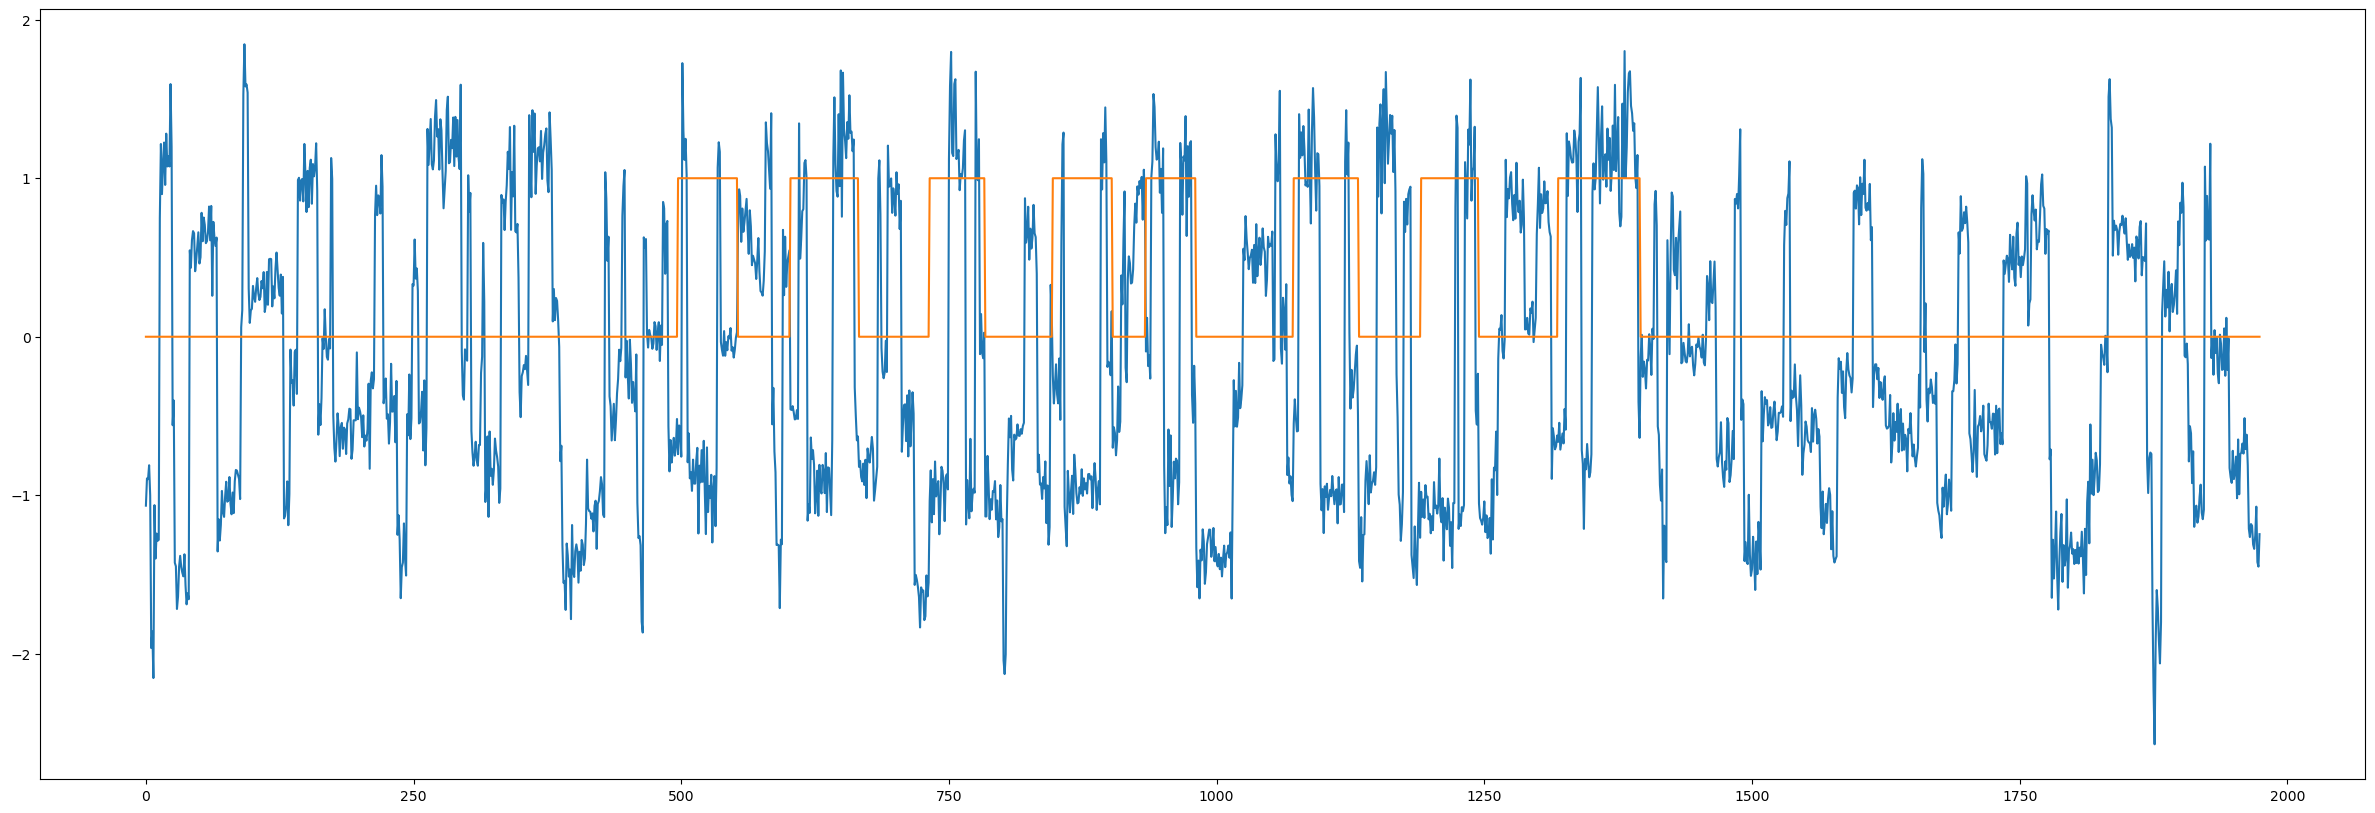

In [28]:
#Create a "SignalDataset" class by importing the Pytorch Dataset class
class Dataset_ctc(Dataset):
    """ Data noisey sinewave dataset
        num_datapoints - the number of datapoints you want
    """
    def __init__(self, x,y):
        self.x_data = x
        self.y_data = y

    #called by the dataLOADER class whenever it wants a new mini-batch
    #returns corresponding input datapoints AND the corresponding labels
    def __getitem__(self, index):
        return {'audio': np.array(self.x_data[index]), 'text': np.array(self.y_data[index]), 'sample_rate': 22050}
        
    #length of the dataset
    def __len__(self):
        return len(self.x_data)

In [29]:

# TODO: wrap to trainer class

parser = argparse.ArgumentParser(description='Training model.')
parser.add_argument('--config', default='configs/train_LJSpeech.yaml',
                    help='path to config file')
args = parser.parse_args("")
with open(args.config, 'r') as f:
    config = edict(yaml.safe_load(f))

def write_to_file(str_w, file_name = 'sth.txt', mode = 'w'):
    with open(file_name,mode) as f:
        f.write(str(str_w))

In [30]:
# config

In [31]:
fix_seeds(seed=config.train.get('seed', 42))
dataset_module = importlib.import_module(
    f'.{config.dataset.name}', data.__name__)
bpe = prepare_bpe(config)

transforms_train = Compose([
    # TextPreprocess(),# removing punctuation in text - might not needed
    # ToNumpy(), # convert audio to numpy
    # BPEtexts(bpe=bpe, dropout_prob=config.bpe.get('dropout_prob', 0.05)),
    # AudioSqueeze(), # remove 1st dimension if it is 1 [1,...]
    # AddGaussianNoise(
    #     min_amplitude=0.001,
    #     max_amplitude=0.015,
    #     p=0.5
    # ),
    # TimeStretch(
    #     min_rate=0.8,
    #     max_rate=1.25,
    #     p=0.5
    # ),
    # PitchShift(
    #     min_semitones=-4,
    #     max_semitones=4,
    #     p=0.5
    # )
    # AddLengths()
])

batch_transforms_train = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    # NormalizedMelSpectrogram(
    #     sample_rate=config.dataset.get('sample_rate', 16000),
    #     n_mels=config.model.feat_in,
    #     normalize=config.dataset.get('normalize', None)
    # ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    # MaskSpectrogram(
    #     probability=0.5,
    #     time_mask_max_percentage=0.05,
    #     frequency_mask_max_percentage=0.15
    # ),
    AddLengths(),
    Pad(),
    AudioUnsqueeze() #! Tin add
])

transforms_val = Compose([
#     TextPreprocess(),
#     ToNumpy(),
#     BPEtexts(bpe=bpe),
#     AudioSqueeze()
])

batch_transforms_val = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    # NormalizedMelSpectrogram(
    #     sample_rate=config.dataset.get(
    #         'sample_rate', 16000),  # for LJspeech
    #     n_mels=config.model.feat_in,
    #     normalize=config.dataset.get('normalize', None)
    # ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    AddLengths(),
    Pad(), # pad both audio and text
    AudioUnsqueeze() #! Tin add
])

# load datasets
# train_dataset = dataset_module.get_dataset(
#     config, transforms=transforms_train, part='train')
# val_dataset = dataset_module.get_dataset(
#     config, transforms=transforms_val, part='val')

# ! TIN Dataset
train_dataset = Dataset_ctc(signals,ctc_labels)
val_dataset = Dataset_ctc(signals,ctc_labels)

# print("!!!", config.train.get('num_workers', 4))
train_dataloader = DataLoader(train_dataset, 
                                batch_size=config.train.get('batch_size', 1), collate_fn=no_pad_collate)

val_dataloader = DataLoader(val_dataset, 
                            batch_size=1, collate_fn=no_pad_collate)

print(getattr(quartznet_configs, config.model.name, '_quartznet5x5_config'))

model = QuartzNet(
    model_config=getattr(
        quartznet_configs, config.model.name, '_quartznet5x5_config'),
    **remove_from_dict(config.model, ['name'])
)
# model = QuartzNet(
#     model_config=getattr(
#         quartznet_configs, config.model.name, '_quartznet5x5_config'),**config)


# print(model)
write_to_file(model,'model_structure.txt')

optimizer = torch.optim.Adam(
    model.parameters(), **config.train.get('optimizer', {}))
num_steps = len(train_dataloader) * config.train.get('epochs', 10)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_steps)
# warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)

if config.train.get('from_checkpoint', None) is not None:
    model.load_weights(config.train.from_checkpoint)

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
# criterion = nn.CTCLoss(blank=config.model.vocab_size)
decoder = GreedyDecoder(bpe=bpe)

prev_wer = 1000
wandb.init(project=config.wandb.project, config=config)
wandb.watch(model, log="all", log_freq=config.wandb.get(
    'log_interval', 5000))